## Imports

In [2]:
# For OS interaction and system-specific parameters
import os
import sys

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A

# PIL for image operations
from PIL import Image

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

# tqdm for showing progress bars
from tqdm.notebook import tqdm

# Import Netron for visualizing our model
import netron

# Add scripts to directory
sys.path.append('/Users/jacob/OneDrive/Desktop/SyntheticEye/Development/scripts')
# Import custom helper functions from the scripts directory
import helper_functions

## Visualize Dimensions of Images
This this is so we can better understand our data and helps us to decide which fixed image size to choose

In [3]:
# Import necessary function from helper_functions.py
from helper_functions import plot_image_dimensions

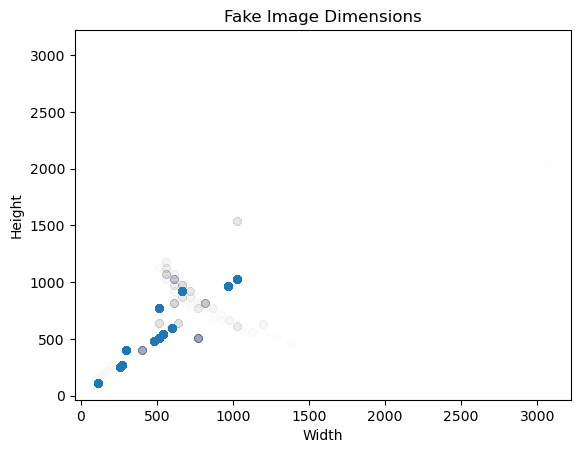

In [9]:
# Plotting dimensions of ai-generated images
img_dir = "/Users/jacob/OneDrive/Desktop/SyntheticEye/Aletheia/Dataset/Fake/"
plot_image_dimensions(img_dir, heading='Fake Image Dimensions', alpha=0.002)

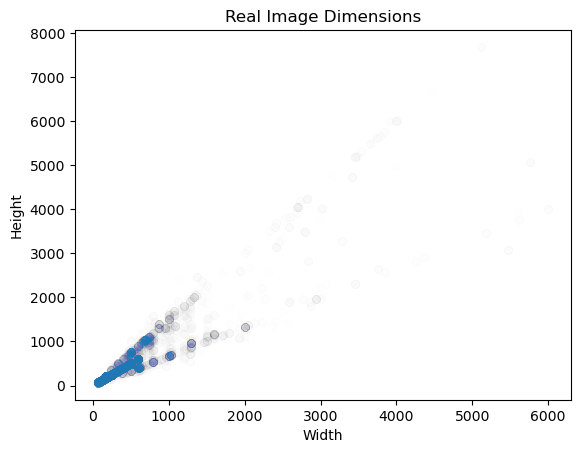

In [5]:
# Plotting dimensions of real images
img_dir = "/Users/jacob/OneDrive/Desktop/SyntheticEye/Aletheia/Dataset/Real/"
plot_image_dimensions(img_dir, heading='Real Image Dimensions', alpha=0.002)

## Create Neural Networks
We experimented with multiple model architectures. The "AdjustedResCNN" is the architecture of Aletheia 2.5 and currently in use on our website.

In [4]:
class CNN(nn.Module):
    """
    A simpler CNN model architecture we used in the beginning.
    This model is fast, but its performance not always optimal.
    """
    def __init__(self, num_classes=2, dropout_prob=0.3):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Applying dropout with lower probability for convolutional layers
        self.dropout_conv = nn.Dropout(p=dropout_prob/3)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 64)

        # Dropout layer for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.dropout_conv(x)

        # Convolutional layer 2 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

In [5]:
class DeeperCNN(nn.Module):
    """
    A deeper CNN that's more complex than the original CNN.
    This model can detect more features but is also slower.
    """
    def __init__(self, dropout_prob=0.3):
        super(DeeperCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 2
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 3
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 4
            nn.Conv2d(128, 224, 3, 1, 1),
            nn.BatchNorm2d(224),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2) # A lower dropout probability for convolutional layers
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(512, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(128, 1)  # Final output layer for our binary classification problem
        )

    def feature_size(self):
        """
        Compute the size of flattened features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers.
        """
        return self.conv_layers(torch.zeros(1, 3, 224, 224)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

In [6]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels as if needed
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is an adjusted version of our DeeperDNN with slight adjustments and the addition of skip connections.
    This is the model architecture of our currently deployed face detection model.
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout probability is reduced for the convolutional layers
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 224, 224)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.3):
        super(ResBlock, self).__init__()

        # Half the out_channels for each branch
        branch_channels = out_channels // 2

        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, 3, 1, 1),
            nn.BatchNorm2d(branch_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )

        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, 5, 1, 2),  # Padding is 2 to keep the same spatial dimensions
            nn.BatchNorm2d(branch_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )

        # Define skip connection and adapt channels
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        # Apply both branches
        out3x3 = self.branch3x3(x)
        out5x5 = self.branch5x5(x)

        # Concatenate along channel dimension
        out = torch.cat([out3x3, out5x5], dim=1)

        # Apply the residual connection
        res = self.residual(x)
        return out + res

class Aletheia3Net(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(Aletheia3Net, self).__init__()

        # Convolutional layers with residual blocks and max-pooling
        self.conv_layers = nn.Sequential(
            ResBlock(3, 16, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(16, 32, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(32, 64, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(64, 128, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(128, 256, dropout_prob * 0.2)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 1)
        )

    def feature_size(self):
        # Testing feature size with 304x304 input
        return self.conv_layers(torch.zeros(1, 3, 304, 304)).view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [8]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Hyperparamters

In [9]:
# Define Hyperparameters
num_classes = 2
learning_rate = 0.0002
batch_size = 32
num_epochs = 36

## Data
- Load Data
- Split Data
- Apply transformations

In [10]:
class AlbumentationsTransform:
    """
    Class to transform images using the Albumentations library
    """
    def __init__(self, transform=None):
        self.transform = transform

    # Apply Albumentations transform to the input image and convert the result to a tensor.
    def __call__(self, img):
        # Convert image to numpy array if needed
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # Convert augmented image to a tensor and normalize pixel values
        augmented = self.transform(image=img)
        img_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float() / 255.0
        return img_tensor

In [11]:
class TorchvisionBridge:
    """
    Bridge to convert Torchvision transforms into a format that can be used with the Albumentations library.
    """
    def __init__(self, transform):
        self.transform = transform

    # Apply torchvision transformations and convert the results to a numpy array
    def __call__(self, img):
        img = self.transform(img)
        return np.array(img)

### Calculate Mean and Std of Images

In [10]:
from helper_functions import get_image_mean_std

dataset_path = "/Users/jacob/OneDrive/Desktop/SyntheticEye/Aletheia/Dataset/"

mean, std = get_image_mean_std(dataset_path)
print(mean)
print(std)

  0%|          | 0/558 [00:00<?, ?it/s]

: 

In [12]:
# Mean and standard deviation for normalization
mean = [0.499, 0.415, 0.372]
std = [0.245, 0.223, 0.220]

In [13]:
# Define image transformations using both Torchvision and Albumentations libraries.

# Torchvision transforms
torchvision_transform = transforms.Compose([
    transforms.RandomAffine(degrees=3, translate=(0.03, 0.03)), # This helps making the model more robust on mobile (since users usually upload screenshots wich have a different positional format than the actual image), but a high value can weaken the accuracy on desktop (when used in the original image resultion).  
    transforms.Resize((304, 304))  # Resize all images to 304x304
])

torchvision_resize = transforms.Compose(
    transforms.Resize((304, 304)),
)

# Albumentation transforms for data augmentation
augmentation = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.06, contrast_limit=0.06, p=0.25),
    A.HorizontalFlip(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.04, rotate_limit=7, p=0.4),
    A.PixelDropout(dropout_prob=0.014, p=0.35),
    A.Normalize(mean=mean, std=std), 
])

# Albumentation transforms for test data, where images are simply resized without additional transformation
test_augmentation = A.Compose([
    A.Resize(304, 304),
    A.Normalize(mean=mean, std=std)
])

In [14]:
class CustomDataset(Dataset):
    """
    This Custom Dataset class is used to incorporate Torchvision and Albumentation transformations.
    """

    # Initialize CustomDataset
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    # Return number of samples in the dataset
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Check if dataset is a subset and get the path and target accordingly
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        img = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            img = self.torchvision_transforms(img)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            img = self.albumentations_transform(img)
        
        return img, target

In [15]:
root_directory = '/Users/jacob/OneDrive/Desktop/SyntheticEye/Aletheia/Dataset/'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(46)

# Split dataset into train, validation, and test sets
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=augmentation
)

val_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)

test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training

### Prepare Training 

In [16]:
# Set a random seed for reproducibility
torch.manual_seed(3)

# Initialize model and transfer it to the GPU if available
model = Aletheia3Net().to(device)

In [19]:
# Use BCEWithLogitsLoss for our binary classification problem
loss_function = nn.BCEWithLogitsLoss()
# Define NAdam (a veriant of the Adam optimizer) as our optimizer
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
# Define learning rate scheduler to adjust our learning rate
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [20]:
# Initialize TensorBoard summary writer
writer = SummaryWriter(f'runs/Aletheia3_0')
step = 0

In [21]:
# Import necessary function for checking accuracy of our model from helper_functions.py
from helper_functions import check_accuracy

### Train Model

In [22]:
# Initialize EmissionsTracker to tracker to monitor carbon emissions using the CodeCarbon library
carbon_tracker = EmissionsTracker(project_name="Aletheia3_0", log_level="critical")
carbon_tracker.start()

# Initialize tracking of correct predictions and total predictions
correct = 0
samples = 0

torch.manual_seed(3)

model = model.to(device)

# Set up log interval for recording metrics
metrics_interval = 250

# Start training
for epoch in range(num_epochs):

    # Reset accuracy counters at beginning of each epoch
    correct = 0
    samples = 0
    
    # Switch model to training mode
    model.train()

    # Train model on each batch of the train_loader and display progress in current epoch using tqdm
    for batch_index, (data, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Progress in epoch"):

        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = loss_function(scores.view(-1), targets.float()) # Compute loss based on model's predictions

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Convert to binary decisions
        preds = (torch.sigmoid(scores) > 0.5).float()

        # Update accuracy counters
        correct += (preds == targets).sum().item()
        samples += preds.size(0)
        # Calculate accuracy as percentage
        accuracy = 100 * correct / samples


        if batch_index % metrics_interval == 0:
            # Log metrics to TensorBoard
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_index)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_index)
            # Print metrics
            print("Epoch: ", epoch)
            print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')


    # Print accumulated accuracy for epoch
    print("Epoch: ", epoch)
    print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')
    scheduler.step()

    # Evaluate the model on validation set after each epoch
    print("Checking accuracy on Test Data")
    correct_test, samples_test = check_accuracy(val_loader, model)
    test_accuracy = 100 * float(correct_test) / float(samples_test)

    # Log test accuracy to TensorBoard
    writer.add_scalar('Test Accuracy', test_accuracy, epoch) 

    # Save state of model after each epcoh
    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/SyntheticEye/SyntheticEyeLocal/StateDicts/Aletheia/3_0/al3_0_epoch_{epoch}_correct{correct}.pth')

# Stop EmmisionsTracker
emissions = carbon_tracker.stop()

# Display total carbon emissions
print(f"Emissions: {emissions:.5f} kgCO2eq")

Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  0
Got 20 / 32 correct with an accuracy 62.50% on training data.
Epoch:  0
Got 4770 / 8032 correct with an accuracy 59.39% on training data.
Epoch:  0
Got 9884 / 16032 correct with an accuracy 61.65% on training data.
Epoch:  0
Got 15353 / 24032 correct with an accuracy 63.89% on training data.
Epoch:  0
Got 21078 / 32032 correct with an accuracy 65.80% on training data.
Epoch:  0
Got 26988 / 40032 correct with an accuracy 67.42% on training data.
Epoch:  0
Got 33027 / 48032 correct with an accuracy 68.76% on training data.
Epoch:  0
Got 39124 / 56032 correct with an accuracy 69.82% on training data.
Epoch:  0
Got 45305 / 64032 correct with an accuracy 70.75% on training data.
Epoch:  0
Got 51547 / 72032 correct with an accuracy 71.56% on training data.
Epoch:  0
Got 57783 / 80032 correct with an accuracy 72.20% on training data.
Epoch:  0
Got 64093 / 88032 correct with an accuracy 72.81% on training data.
Epoch:  0
Got 70421 / 96032 correct with an accuracy 73.33% on training d

c:\Users\jacob\miniconda3\envs\env_two\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:  0
Got 83158 / 112032 correct with an accuracy 74.23% on training data.
Epoch:  0
Got 89551 / 120032 correct with an accuracy 74.61% on training data.
Epoch:  0
Got 96032 / 128032 correct with an accuracy 75.01% on training data.
Epoch:  0
Got 102571 / 136032 correct with an accuracy 75.40% on training data.
Epoch:  0
Got 109079 / 144032 correct with an accuracy 75.73% on training data.
Epoch:  0
Got 115556 / 152032 correct with an accuracy 76.01% on training data.
Epoch:  0
Got 122058 / 160032 correct with an accuracy 76.27% on training data.
Epoch:  0
Got 128612 / 168032 correct with an accuracy 76.54% on training data.
Epoch:  0
Got 135198 / 176032 correct with an accuracy 76.80% on training data.
Epoch:  0
Got 141771 / 184032 correct with an accuracy 77.04% on training data.
Epoch:  0
Got 148406 / 192032 correct with an accuracy 77.28% on training data.
Epoch:  0
Got 155046 / 200032 correct with an accuracy 77.51% on training data.
Epoch:  0
Got 161670 / 208032 correct with 

100%|██████████| 446/446 [02:35<00:00,  2.86it/s]

Got 10906 / 14267 correct with an accuracy of 76.44%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  1
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  1
Got 6758 / 8032 correct with an accuracy 84.14% on training data.
Epoch:  1
Got 13528 / 16032 correct with an accuracy 84.38% on training data.
Epoch:  1
Got 20348 / 24032 correct with an accuracy 84.67% on training data.
Epoch:  1
Got 27196 / 32032 correct with an accuracy 84.90% on training data.
Epoch:  1
Got 34049 / 40032 correct with an accuracy 85.05% on training data.
Epoch:  1
Got 40857 / 48032 correct with an accuracy 85.06% on training data.
Epoch:  1
Got 47764 / 56032 correct with an accuracy 85.24% on training data.
Epoch:  1
Got 54680 / 64032 correct with an accuracy 85.39% on training data.
Epoch:  1
Got 61599 / 72032 correct with an accuracy 85.52% on training data.
Epoch:  1
Got 68483 / 80032 correct with an accuracy 85.57% on training data.
Epoch:  1
Got 75424 / 88032 correct with an accuracy 85.68% on training data.
Epoch:  1
Got 82314 / 96032 correct with an accuracy 85.72% on training 

100%|██████████| 446/446 [02:35<00:00,  2.87it/s]

Got 11225 / 14267 correct with an accuracy of 78.68%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  2
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  2
Got 7241 / 8032 correct with an accuracy 90.15% on training data.
Epoch:  2
Got 14380 / 16032 correct with an accuracy 89.70% on training data.
Epoch:  2
Got 21651 / 24032 correct with an accuracy 90.09% on training data.
Epoch:  2
Got 28868 / 32032 correct with an accuracy 90.12% on training data.
Epoch:  2
Got 36104 / 40032 correct with an accuracy 90.19% on training data.
Epoch:  2
Got 43352 / 48032 correct with an accuracy 90.26% on training data.
Epoch:  2
Got 50629 / 56032 correct with an accuracy 90.36% on training data.
Epoch:  2
Got 57862 / 64032 correct with an accuracy 90.36% on training data.
Epoch:  2
Got 65157 / 72032 correct with an accuracy 90.46% on training data.
Epoch:  2
Got 72425 / 80032 correct with an accuracy 90.50% on training data.
Epoch:  2
Got 79725 / 88032 correct with an accuracy 90.56% on training data.
Epoch:  2
Got 87002 / 96032 correct with an accuracy 90.60% on training 

100%|██████████| 446/446 [02:39<00:00,  2.80it/s]

Got 10556 / 14267 correct with an accuracy of 73.99%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  3
Got 28 / 32 correct with an accuracy 87.50% on training data.
Epoch:  3
Got 7480 / 8032 correct with an accuracy 93.13% on training data.
Epoch:  3
Got 14921 / 16032 correct with an accuracy 93.07% on training data.
Epoch:  3
Got 22369 / 24032 correct with an accuracy 93.08% on training data.
Epoch:  3
Got 29838 / 32032 correct with an accuracy 93.15% on training data.
Epoch:  3
Got 37247 / 40032 correct with an accuracy 93.04% on training data.
Epoch:  3
Got 44678 / 48032 correct with an accuracy 93.02% on training data.
Epoch:  3
Got 52121 / 56032 correct with an accuracy 93.02% on training data.
Epoch:  3
Got 59619 / 64032 correct with an accuracy 93.11% on training data.
Epoch:  3
Got 67112 / 72032 correct with an accuracy 93.17% on training data.
Epoch:  3
Got 74559 / 80032 correct with an accuracy 93.16% on training data.
Epoch:  3
Got 82002 / 88032 correct with an accuracy 93.15% on training data.
Epoch:  3
Got 89459 / 96032 correct with an accuracy 93.16% on training 

100%|██████████| 446/446 [02:34<00:00,  2.89it/s]

Got 13310 / 14267 correct with an accuracy of 93.29%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  4
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  4
Got 7636 / 8032 correct with an accuracy 95.07% on training data.
Epoch:  4
Got 15234 / 16032 correct with an accuracy 95.02% on training data.
Epoch:  4
Got 22792 / 24032 correct with an accuracy 94.84% on training data.
Epoch:  4
Got 30383 / 32032 correct with an accuracy 94.85% on training data.
Epoch:  4
Got 37977 / 40032 correct with an accuracy 94.87% on training data.
Epoch:  4
Got 45596 / 48032 correct with an accuracy 94.93% on training data.
Epoch:  4
Got 53212 / 56032 correct with an accuracy 94.97% on training data.
Epoch:  4
Got 60799 / 64032 correct with an accuracy 94.95% on training data.
Epoch:  4
Got 68378 / 72032 correct with an accuracy 94.93% on training data.
Epoch:  4
Got 75989 / 80032 correct with an accuracy 94.95% on training data.
Epoch:  4
Got 83558 / 88032 correct with an accuracy 94.92% on training data.
Epoch:  4
Got 91155 / 96032 correct with an accuracy 94.92% on training 

100%|██████████| 446/446 [02:35<00:00,  2.88it/s]

Got 13562 / 14267 correct with an accuracy of 95.06%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  5
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  5
Got 7695 / 8032 correct with an accuracy 95.80% on training data.
Epoch:  5
Got 15360 / 16032 correct with an accuracy 95.81% on training data.
Epoch:  5
Got 23032 / 24032 correct with an accuracy 95.84% on training data.
Epoch:  5
Got 30705 / 32032 correct with an accuracy 95.86% on training data.
Epoch:  5
Got 38364 / 40032 correct with an accuracy 95.83% on training data.
Epoch:  5
Got 46058 / 48032 correct with an accuracy 95.89% on training data.
Epoch:  5
Got 53713 / 56032 correct with an accuracy 95.86% on training data.
Epoch:  5
Got 61386 / 64032 correct with an accuracy 95.87% on training data.
Epoch:  5
Got 69059 / 72032 correct with an accuracy 95.87% on training data.
Epoch:  5
Got 76746 / 80032 correct with an accuracy 95.89% on training data.
Epoch:  5
Got 84377 / 88032 correct with an accuracy 95.85% on training data.
Epoch:  5
Got 92044 / 96032 correct with an accuracy 95.85% on training 

100%|██████████| 446/446 [02:36<00:00,  2.85it/s]

Got 10565 / 14267 correct with an accuracy of 74.05%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  6
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  6
Got 7754 / 8032 correct with an accuracy 96.54% on training data.
Epoch:  6
Got 15464 / 16032 correct with an accuracy 96.46% on training data.
Epoch:  6
Got 23175 / 24032 correct with an accuracy 96.43% on training data.
Epoch:  6
Got 30890 / 32032 correct with an accuracy 96.43% on training data.
Epoch:  6
Got 38634 / 40032 correct with an accuracy 96.51% on training data.
Epoch:  6
Got 46337 / 48032 correct with an accuracy 96.47% on training data.
Epoch:  6
Got 54069 / 56032 correct with an accuracy 96.50% on training data.
Epoch:  6
Got 61750 / 64032 correct with an accuracy 96.44% on training data.
Epoch:  6
Got 69455 / 72032 correct with an accuracy 96.42% on training data.
Epoch:  6
Got 77129 / 80032 correct with an accuracy 96.37% on training data.
Epoch:  6
Got 84851 / 88032 correct with an accuracy 96.39% on training data.
Epoch:  6
Got 92559 / 96032 correct with an accuracy 96.38% on training 

100%|██████████| 446/446 [02:34<00:00,  2.89it/s]

Got 12431 / 14267 correct with an accuracy of 87.13%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  7
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  7
Got 7783 / 8032 correct with an accuracy 96.90% on training data.
Epoch:  7
Got 15540 / 16032 correct with an accuracy 96.93% on training data.
Epoch:  7
Got 23278 / 24032 correct with an accuracy 96.86% on training data.
Epoch:  7
Got 31037 / 32032 correct with an accuracy 96.89% on training data.
Epoch:  7
Got 38740 / 40032 correct with an accuracy 96.77% on training data.
Epoch:  7
Got 46515 / 48032 correct with an accuracy 96.84% on training data.
Epoch:  7
Got 54249 / 56032 correct with an accuracy 96.82% on training data.
Epoch:  7
Got 61995 / 64032 correct with an accuracy 96.82% on training data.
Epoch:  7
Got 69757 / 72032 correct with an accuracy 96.84% on training data.
Epoch:  7
Got 77471 / 80032 correct with an accuracy 96.80% on training data.
Epoch:  7
Got 85193 / 88032 correct with an accuracy 96.78% on training data.
Epoch:  7
Got 92947 / 96032 correct with an accuracy 96.79% on training

100%|██████████| 446/446 [02:35<00:00,  2.86it/s]

Got 13771 / 14267 correct with an accuracy of 96.52%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  8
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  8
Got 7793 / 8032 correct with an accuracy 97.02% on training data.
Epoch:  8
Got 15550 / 16032 correct with an accuracy 96.99% on training data.
Epoch:  8
Got 23351 / 24032 correct with an accuracy 97.17% on training data.
Epoch:  8
Got 31120 / 32032 correct with an accuracy 97.15% on training data.
Epoch:  8
Got 38906 / 40032 correct with an accuracy 97.19% on training data.
Epoch:  8
Got 46713 / 48032 correct with an accuracy 97.25% on training data.
Epoch:  8
Got 54503 / 56032 correct with an accuracy 97.27% on training data.
Epoch:  8
Got 62255 / 64032 correct with an accuracy 97.22% on training data.
Epoch:  8
Got 70033 / 72032 correct with an accuracy 97.22% on training data.
Epoch:  8
Got 77793 / 80032 correct with an accuracy 97.20% on training data.
Epoch:  8
Got 85600 / 88032 correct with an accuracy 97.24% on training data.
Epoch:  8
Got 93405 / 96032 correct with an accuracy 97.26% on training 

100%|██████████| 446/446 [02:35<00:00,  2.87it/s]

Got 13889 / 14267 correct with an accuracy of 97.35%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  9
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  9
Got 7835 / 8032 correct with an accuracy 97.55% on training data.
Epoch:  9
Got 15658 / 16032 correct with an accuracy 97.67% on training data.
Epoch:  9
Got 23471 / 24032 correct with an accuracy 97.67% on training data.
Epoch:  9
Got 31293 / 32032 correct with an accuracy 97.69% on training data.
Epoch:  9
Got 39099 / 40032 correct with an accuracy 97.67% on training data.
Epoch:  9
Got 46906 / 48032 correct with an accuracy 97.66% on training data.
Epoch:  9
Got 54730 / 56032 correct with an accuracy 97.68% on training data.
Epoch:  9
Got 62524 / 64032 correct with an accuracy 97.64% on training data.
Epoch:  9
Got 70321 / 72032 correct with an accuracy 97.62% on training data.
Epoch:  9
Got 78166 / 80032 correct with an accuracy 97.67% on training data.
Epoch:  9
Got 85954 / 88032 correct with an accuracy 97.64% on training data.
Epoch:  9
Got 93753 / 96032 correct with an accuracy 97.63% on training

100%|██████████| 446/446 [02:35<00:00,  2.86it/s]

Got 13835 / 14267 correct with an accuracy of 96.97%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  10
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  10
Got 7857 / 8032 correct with an accuracy 97.82% on training data.
Epoch:  10
Got 15687 / 16032 correct with an accuracy 97.85% on training data.
Epoch:  10
Got 23499 / 24032 correct with an accuracy 97.78% on training data.
Epoch:  10
Got 31323 / 32032 correct with an accuracy 97.79% on training data.
Epoch:  10
Got 39138 / 40032 correct with an accuracy 97.77% on training data.
Epoch:  10
Got 46957 / 48032 correct with an accuracy 97.76% on training data.
Epoch:  10
Got 54788 / 56032 correct with an accuracy 97.78% on training data.
Epoch:  10
Got 62599 / 64032 correct with an accuracy 97.76% on training data.
Epoch:  10
Got 70429 / 72032 correct with an accuracy 97.77% on training data.
Epoch:  10
Got 78230 / 80032 correct with an accuracy 97.75% on training data.
Epoch:  10
Got 86042 / 88032 correct with an accuracy 97.74% on training data.
Epoch:  10
Got 93853 / 96032 correct with an accuracy 97.73%

100%|██████████| 446/446 [02:35<00:00,  2.88it/s]

Got 13954 / 14267 correct with an accuracy of 97.81%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  11
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  11
Got 7851 / 8032 correct with an accuracy 97.75% on training data.
Epoch:  11
Got 15676 / 16032 correct with an accuracy 97.78% on training data.
Epoch:  11
Got 23499 / 24032 correct with an accuracy 97.78% on training data.
Epoch:  11
Got 31336 / 32032 correct with an accuracy 97.83% on training data.
Epoch:  11
Got 39188 / 40032 correct with an accuracy 97.89% on training data.
Epoch:  11
Got 47020 / 48032 correct with an accuracy 97.89% on training data.
Epoch:  11
Got 54868 / 56032 correct with an accuracy 97.92% on training data.
Epoch:  11
Got 62735 / 64032 correct with an accuracy 97.97% on training data.
Epoch:  11
Got 70543 / 72032 correct with an accuracy 97.93% on training data.
Epoch:  11
Got 78371 / 80032 correct with an accuracy 97.92% on training data.
Epoch:  11
Got 86208 / 88032 correct with an accuracy 97.93% on training data.
Epoch:  11
Got 94046 / 96032 correct with an accuracy 97.93%

100%|██████████| 446/446 [02:36<00:00,  2.86it/s]

Got 13810 / 14267 correct with an accuracy of 96.80%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  12
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  12
Got 7898 / 8032 correct with an accuracy 98.33% on training data.
Epoch:  12
Got 15779 / 16032 correct with an accuracy 98.42% on training data.
Epoch:  12
Got 23629 / 24032 correct with an accuracy 98.32% on training data.
Epoch:  12
Got 31481 / 32032 correct with an accuracy 98.28% on training data.
Epoch:  12
Got 39340 / 40032 correct with an accuracy 98.27% on training data.
Epoch:  12
Got 47210 / 48032 correct with an accuracy 98.29% on training data.
Epoch:  12
Got 55066 / 56032 correct with an accuracy 98.28% on training data.
Epoch:  12
Got 62935 / 64032 correct with an accuracy 98.29% on training data.
Epoch:  12
Got 70793 / 72032 correct with an accuracy 98.28% on training data.
Epoch:  12
Got 78640 / 80032 correct with an accuracy 98.26% on training data.
Epoch:  12
Got 86471 / 88032 correct with an accuracy 98.23% on training data.
Epoch:  12
Got 94320 / 96032 correct with an accuracy 98.22

100%|██████████| 446/446 [02:34<00:00,  2.89it/s]

Got 13909 / 14267 correct with an accuracy of 97.49%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  13
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  13
Got 7899 / 8032 correct with an accuracy 98.34% on training data.
Epoch:  13
Got 15768 / 16032 correct with an accuracy 98.35% on training data.
Epoch:  13
Got 23648 / 24032 correct with an accuracy 98.40% on training data.
Epoch:  13
Got 31502 / 32032 correct with an accuracy 98.35% on training data.
Epoch:  13
Got 39370 / 40032 correct with an accuracy 98.35% on training data.
Epoch:  13
Got 47235 / 48032 correct with an accuracy 98.34% on training data.
Epoch:  13
Got 55116 / 56032 correct with an accuracy 98.37% on training data.
Epoch:  13
Got 63001 / 64032 correct with an accuracy 98.39% on training data.
Epoch:  13
Got 70867 / 72032 correct with an accuracy 98.38% on training data.
Epoch:  13
Got 78733 / 80032 correct with an accuracy 98.38% on training data.
Epoch:  13
Got 86591 / 88032 correct with an accuracy 98.36% on training data.
Epoch:  13
Got 94461 / 96032 correct with an accuracy 98.36

100%|██████████| 446/446 [02:34<00:00,  2.88it/s]

Got 13809 / 14267 correct with an accuracy of 96.79%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  14
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  14
Got 7907 / 8032 correct with an accuracy 98.44% on training data.
Epoch:  14
Got 15775 / 16032 correct with an accuracy 98.40% on training data.
Epoch:  14
Got 23659 / 24032 correct with an accuracy 98.45% on training data.
Epoch:  14
Got 31518 / 32032 correct with an accuracy 98.40% on training data.
Epoch:  14
Got 39401 / 40032 correct with an accuracy 98.42% on training data.
Epoch:  14
Got 47294 / 48032 correct with an accuracy 98.46% on training data.
Epoch:  14
Got 55132 / 56032 correct with an accuracy 98.39% on training data.
Epoch:  14
Got 63028 / 64032 correct with an accuracy 98.43% on training data.
Epoch:  14
Got 70911 / 72032 correct with an accuracy 98.44% on training data.
Epoch:  14
Got 78791 / 80032 correct with an accuracy 98.45% on training data.
Epoch:  14
Got 86662 / 88032 correct with an accuracy 98.44% on training data.
Epoch:  14
Got 94544 / 96032 correct with an accuracy 98.45%

100%|██████████| 446/446 [02:35<00:00,  2.87it/s]

Got 13997 / 14267 correct with an accuracy of 98.11%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  15
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  15
Got 7913 / 8032 correct with an accuracy 98.52% on training data.
Epoch:  15
Got 15788 / 16032 correct with an accuracy 98.48% on training data.
Epoch:  15
Got 23669 / 24032 correct with an accuracy 98.49% on training data.
Epoch:  15
Got 31525 / 32032 correct with an accuracy 98.42% on training data.
Epoch:  15
Got 39416 / 40032 correct with an accuracy 98.46% on training data.
Epoch:  15
Got 47291 / 48032 correct with an accuracy 98.46% on training data.
Epoch:  15
Got 55161 / 56032 correct with an accuracy 98.45% on training data.
Epoch:  15
Got 63038 / 64032 correct with an accuracy 98.45% on training data.
Epoch:  15
Got 70934 / 72032 correct with an accuracy 98.48% on training data.
Epoch:  15
Got 78814 / 80032 correct with an accuracy 98.48% on training data.
Epoch:  15
Got 86685 / 88032 correct with an accuracy 98.47% on training data.
Epoch:  15
Got 94571 / 96032 correct with an accuracy 98.48

100%|██████████| 446/446 [02:36<00:00,  2.86it/s]

Got 13981 / 14267 correct with an accuracy of 98.00%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  16
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  16
Got 7936 / 8032 correct with an accuracy 98.80% on training data.
Epoch:  16
Got 15825 / 16032 correct with an accuracy 98.71% on training data.
Epoch:  16
Got 23723 / 24032 correct with an accuracy 98.71% on training data.
Epoch:  16
Got 31592 / 32032 correct with an accuracy 98.63% on training data.
Epoch:  16
Got 39486 / 40032 correct with an accuracy 98.64% on training data.
Epoch:  16
Got 47377 / 48032 correct with an accuracy 98.64% on training data.
Epoch:  16
Got 55274 / 56032 correct with an accuracy 98.65% on training data.
Epoch:  16
Got 63168 / 64032 correct with an accuracy 98.65% on training data.
Epoch:  16
Got 71056 / 72032 correct with an accuracy 98.65% on training data.
Epoch:  16
Got 78922 / 80032 correct with an accuracy 98.61% on training data.
Epoch:  16
Got 86796 / 88032 correct with an accuracy 98.60% on training data.
Epoch:  16
Got 94694 / 96032 correct with an accuracy 98.61

100%|██████████| 446/446 [02:36<00:00,  2.85it/s]

Got 14018 / 14267 correct with an accuracy of 98.25%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  17
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  17
Got 7936 / 8032 correct with an accuracy 98.80% on training data.
Epoch:  17
Got 15823 / 16032 correct with an accuracy 98.70% on training data.
Epoch:  17
Got 23734 / 24032 correct with an accuracy 98.76% on training data.
Epoch:  17
Got 31634 / 32032 correct with an accuracy 98.76% on training data.
Epoch:  17
Got 39523 / 40032 correct with an accuracy 98.73% on training data.
Epoch:  17
Got 47406 / 48032 correct with an accuracy 98.70% on training data.
Epoch:  17
Got 55298 / 56032 correct with an accuracy 98.69% on training data.
Epoch:  17
Got 63190 / 64032 correct with an accuracy 98.69% on training data.
Epoch:  17
Got 71090 / 72032 correct with an accuracy 98.69% on training data.
Epoch:  17
Got 78986 / 80032 correct with an accuracy 98.69% on training data.
Epoch:  17
Got 86887 / 88032 correct with an accuracy 98.70% on training data.
Epoch:  17
Got 94772 / 96032 correct with an accuracy 98.69

100%|██████████| 446/446 [02:31<00:00,  2.95it/s]

Got 14040 / 14267 correct with an accuracy of 98.41%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  18
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  18
Got 7909 / 8032 correct with an accuracy 98.47% on training data.
Epoch:  18
Got 15811 / 16032 correct with an accuracy 98.62% on training data.
Epoch:  18
Got 23728 / 24032 correct with an accuracy 98.74% on training data.
Epoch:  18
Got 31635 / 32032 correct with an accuracy 98.76% on training data.
Epoch:  18
Got 39532 / 40032 correct with an accuracy 98.75% on training data.
Epoch:  18
Got 47427 / 48032 correct with an accuracy 98.74% on training data.
Epoch:  18
Got 55330 / 56032 correct with an accuracy 98.75% on training data.
Epoch:  18
Got 63216 / 64032 correct with an accuracy 98.73% on training data.
Epoch:  18
Got 71102 / 72032 correct with an accuracy 98.71% on training data.
Epoch:  18
Got 79004 / 80032 correct with an accuracy 98.72% on training data.
Epoch:  18
Got 86907 / 88032 correct with an accuracy 98.72% on training data.
Epoch:  18
Got 94818 / 96032 correct with an accuracy 98.74%

100%|██████████| 446/446 [02:31<00:00,  2.95it/s]

Got 14024 / 14267 correct with an accuracy of 98.30%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  19
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  19
Got 7941 / 8032 correct with an accuracy 98.87% on training data.
Epoch:  19
Got 15860 / 16032 correct with an accuracy 98.93% on training data.
Epoch:  19
Got 23769 / 24032 correct with an accuracy 98.91% on training data.
Epoch:  19
Got 31677 / 32032 correct with an accuracy 98.89% on training data.
Epoch:  19
Got 39587 / 40032 correct with an accuracy 98.89% on training data.
Epoch:  19
Got 47484 / 48032 correct with an accuracy 98.86% on training data.
Epoch:  19
Got 55383 / 56032 correct with an accuracy 98.84% on training data.
Epoch:  19
Got 63270 / 64032 correct with an accuracy 98.81% on training data.
Epoch:  19
Got 71170 / 72032 correct with an accuracy 98.80% on training data.
Epoch:  19
Got 79085 / 80032 correct with an accuracy 98.82% on training data.
Epoch:  19
Got 86997 / 88032 correct with an accuracy 98.82% on training data.
Epoch:  19
Got 94904 / 96032 correct with an accuracy 98.83

100%|██████████| 446/446 [02:31<00:00,  2.94it/s]

Got 13998 / 14267 correct with an accuracy of 98.11%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  20
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  20
Got 7945 / 8032 correct with an accuracy 98.92% on training data.
Epoch:  20
Got 15842 / 16032 correct with an accuracy 98.81% on training data.
Epoch:  20
Got 23766 / 24032 correct with an accuracy 98.89% on training data.
Epoch:  20
Got 31681 / 32032 correct with an accuracy 98.90% on training data.
Epoch:  20
Got 39595 / 40032 correct with an accuracy 98.91% on training data.
Epoch:  20
Got 47498 / 48032 correct with an accuracy 98.89% on training data.
Epoch:  20
Got 55409 / 56032 correct with an accuracy 98.89% on training data.
Epoch:  20
Got 63326 / 64032 correct with an accuracy 98.90% on training data.
Epoch:  20
Got 71252 / 72032 correct with an accuracy 98.92% on training data.
Epoch:  20
Got 79162 / 80032 correct with an accuracy 98.91% on training data.
Epoch:  20
Got 87062 / 88032 correct with an accuracy 98.90% on training data.
Epoch:  20
Got 94963 / 96032 correct with an accuracy 98.89%

100%|██████████| 446/446 [02:31<00:00,  2.94it/s]

Got 14074 / 14267 correct with an accuracy of 98.65%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  21
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  21
Got 7955 / 8032 correct with an accuracy 99.04% on training data.
Epoch:  21
Got 15877 / 16032 correct with an accuracy 99.03% on training data.
Epoch:  21
Got 23783 / 24032 correct with an accuracy 98.96% on training data.
Epoch:  21
Got 31686 / 32032 correct with an accuracy 98.92% on training data.
Epoch:  21
Got 39596 / 40032 correct with an accuracy 98.91% on training data.
Epoch:  21
Got 47530 / 48032 correct with an accuracy 98.95% on training data.
Epoch:  21
Got 55454 / 56032 correct with an accuracy 98.97% on training data.
Epoch:  21
Got 63366 / 64032 correct with an accuracy 98.96% on training data.
Epoch:  21
Got 71282 / 72032 correct with an accuracy 98.96% on training data.
Epoch:  21
Got 79192 / 80032 correct with an accuracy 98.95% on training data.
Epoch:  21
Got 87119 / 88032 correct with an accuracy 98.96% on training data.
Epoch:  21
Got 95047 / 96032 correct with an accuracy 98.97%

100%|██████████| 446/446 [02:32<00:00,  2.93it/s]

Got 13991 / 14267 correct with an accuracy of 98.07%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  22
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  22
Got 7949 / 8032 correct with an accuracy 98.97% on training data.
Epoch:  22
Got 15857 / 16032 correct with an accuracy 98.91% on training data.
Epoch:  22
Got 23774 / 24032 correct with an accuracy 98.93% on training data.
Epoch:  22
Got 31708 / 32032 correct with an accuracy 98.99% on training data.
Epoch:  22
Got 39621 / 40032 correct with an accuracy 98.97% on training data.
Epoch:  22
Got 47542 / 48032 correct with an accuracy 98.98% on training data.
Epoch:  22
Got 55466 / 56032 correct with an accuracy 98.99% on training data.
Epoch:  22
Got 63392 / 64032 correct with an accuracy 99.00% on training data.
Epoch:  22
Got 71311 / 72032 correct with an accuracy 99.00% on training data.
Epoch:  22
Got 79229 / 80032 correct with an accuracy 99.00% on training data.
Epoch:  22
Got 87153 / 88032 correct with an accuracy 99.00% on training data.
Epoch:  22
Got 95071 / 96032 correct with an accuracy 99.00%

100%|██████████| 446/446 [02:32<00:00,  2.92it/s]

Got 14093 / 14267 correct with an accuracy of 98.78%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  23
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  23
Got 7952 / 8032 correct with an accuracy 99.00% on training data.
Epoch:  23
Got 15870 / 16032 correct with an accuracy 98.99% on training data.
Epoch:  23
Got 23777 / 24032 correct with an accuracy 98.94% on training data.
Epoch:  23
Got 31683 / 32032 correct with an accuracy 98.91% on training data.
Epoch:  23
Got 39620 / 40032 correct with an accuracy 98.97% on training data.
Epoch:  23
Got 47528 / 48032 correct with an accuracy 98.95% on training data.
Epoch:  23
Got 55449 / 56032 correct with an accuracy 98.96% on training data.
Epoch:  23
Got 63373 / 64032 correct with an accuracy 98.97% on training data.
Epoch:  23
Got 71308 / 72032 correct with an accuracy 98.99% on training data.
Epoch:  23
Got 79247 / 80032 correct with an accuracy 99.02% on training data.
Epoch:  23
Got 87175 / 88032 correct with an accuracy 99.03% on training data.
Epoch:  23
Got 95082 / 96032 correct with an accuracy 99.01

100%|██████████| 446/446 [02:37<00:00,  2.83it/s]

Got 14080 / 14267 correct with an accuracy of 98.69%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  24
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  24
Got 7942 / 8032 correct with an accuracy 98.88% on training data.
Epoch:  24
Got 15864 / 16032 correct with an accuracy 98.95% on training data.
Epoch:  24
Got 23777 / 24032 correct with an accuracy 98.94% on training data.
Epoch:  24
Got 31693 / 32032 correct with an accuracy 98.94% on training data.
Epoch:  24
Got 39621 / 40032 correct with an accuracy 98.97% on training data.
Epoch:  24
Got 47545 / 48032 correct with an accuracy 98.99% on training data.
Epoch:  24
Got 55457 / 56032 correct with an accuracy 98.97% on training data.
Epoch:  24
Got 63380 / 64032 correct with an accuracy 98.98% on training data.
Epoch:  24
Got 71312 / 72032 correct with an accuracy 99.00% on training data.
Epoch:  24
Got 79239 / 80032 correct with an accuracy 99.01% on training data.
Epoch:  24
Got 87159 / 88032 correct with an accuracy 99.01% on training data.
Epoch:  24
Got 95087 / 96032 correct with an accuracy 99.02%

100%|██████████| 446/446 [02:33<00:00,  2.90it/s]

Got 14080 / 14267 correct with an accuracy of 98.69%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  25
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  25
Got 7954 / 8032 correct with an accuracy 99.03% on training data.
Epoch:  25
Got 15870 / 16032 correct with an accuracy 98.99% on training data.
Epoch:  25
Got 23783 / 24032 correct with an accuracy 98.96% on training data.
Epoch:  25
Got 31710 / 32032 correct with an accuracy 98.99% on training data.
Epoch:  25
Got 39626 / 40032 correct with an accuracy 98.99% on training data.
Epoch:  25
Got 47556 / 48032 correct with an accuracy 99.01% on training data.
Epoch:  25
Got 55481 / 56032 correct with an accuracy 99.02% on training data.
Epoch:  25
Got 63394 / 64032 correct with an accuracy 99.00% on training data.
Epoch:  25
Got 71313 / 72032 correct with an accuracy 99.00% on training data.
Epoch:  25
Got 79243 / 80032 correct with an accuracy 99.01% on training data.
Epoch:  25
Got 87169 / 88032 correct with an accuracy 99.02% on training data.
Epoch:  25
Got 95089 / 96032 correct with an accuracy 99.02

100%|██████████| 446/446 [02:20<00:00,  3.18it/s]

Got 14072 / 14267 correct with an accuracy of 98.63%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  26
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  26
Got 7970 / 8032 correct with an accuracy 99.23% on training data.
Epoch:  26
Got 15899 / 16032 correct with an accuracy 99.17% on training data.
Epoch:  26
Got 23821 / 24032 correct with an accuracy 99.12% on training data.
Epoch:  26
Got 31755 / 32032 correct with an accuracy 99.14% on training data.
Epoch:  26
Got 39677 / 40032 correct with an accuracy 99.11% on training data.
Epoch:  26
Got 47613 / 48032 correct with an accuracy 99.13% on training data.
Epoch:  26
Got 55546 / 56032 correct with an accuracy 99.13% on training data.
Epoch:  26
Got 63495 / 64032 correct with an accuracy 99.16% on training data.
Epoch:  26
Got 71436 / 72032 correct with an accuracy 99.17% on training data.
Epoch:  26
Got 79366 / 80032 correct with an accuracy 99.17% on training data.
Epoch:  26
Got 87288 / 88032 correct with an accuracy 99.15% on training data.
Epoch:  26
Got 95222 / 96032 correct with an accuracy 99.16

100%|██████████| 446/446 [02:19<00:00,  3.20it/s]

Got 14093 / 14267 correct with an accuracy of 98.78%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  27
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  27
Got 7976 / 8032 correct with an accuracy 99.30% on training data.
Epoch:  27
Got 15896 / 16032 correct with an accuracy 99.15% on training data.
Epoch:  27
Got 23824 / 24032 correct with an accuracy 99.13% on training data.
Epoch:  27
Got 31761 / 32032 correct with an accuracy 99.15% on training data.
Epoch:  27
Got 39693 / 40032 correct with an accuracy 99.15% on training data.
Epoch:  27
Got 47640 / 48032 correct with an accuracy 99.18% on training data.
Epoch:  27
Got 55563 / 56032 correct with an accuracy 99.16% on training data.
Epoch:  27
Got 63496 / 64032 correct with an accuracy 99.16% on training data.
Epoch:  27
Got 71415 / 72032 correct with an accuracy 99.14% on training data.
Epoch:  27
Got 79344 / 80032 correct with an accuracy 99.14% on training data.
Epoch:  27
Got 87283 / 88032 correct with an accuracy 99.15% on training data.
Epoch:  27
Got 95210 / 96032 correct with an accuracy 99.14

100%|██████████| 446/446 [02:35<00:00,  2.87it/s]

Got 14073 / 14267 correct with an accuracy of 98.64%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  28
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  28
Got 7958 / 8032 correct with an accuracy 99.08% on training data.
Epoch:  28
Got 15901 / 16032 correct with an accuracy 99.18% on training data.
Epoch:  28
Got 23845 / 24032 correct with an accuracy 99.22% on training data.
Epoch:  28
Got 31783 / 32032 correct with an accuracy 99.22% on training data.
Epoch:  28
Got 39720 / 40032 correct with an accuracy 99.22% on training data.
Epoch:  28
Got 47666 / 48032 correct with an accuracy 99.24% on training data.
Epoch:  28
Got 55606 / 56032 correct with an accuracy 99.24% on training data.
Epoch:  28
Got 63545 / 64032 correct with an accuracy 99.24% on training data.
Epoch:  28
Got 71484 / 72032 correct with an accuracy 99.24% on training data.
Epoch:  28
Got 79420 / 80032 correct with an accuracy 99.24% on training data.
Epoch:  28
Got 87349 / 88032 correct with an accuracy 99.22% on training data.
Epoch:  28
Got 95266 / 96032 correct with an accuracy 99.20

100%|██████████| 446/446 [02:34<00:00,  2.88it/s]

Got 14018 / 14267 correct with an accuracy of 98.25%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  29
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  29
Got 7965 / 8032 correct with an accuracy 99.17% on training data.
Epoch:  29
Got 15898 / 16032 correct with an accuracy 99.16% on training data.
Epoch:  29
Got 23839 / 24032 correct with an accuracy 99.20% on training data.
Epoch:  29
Got 31774 / 32032 correct with an accuracy 99.19% on training data.
Epoch:  29
Got 39719 / 40032 correct with an accuracy 99.22% on training data.
Epoch:  29
Got 47638 / 48032 correct with an accuracy 99.18% on training data.
Epoch:  29
Got 55573 / 56032 correct with an accuracy 99.18% on training data.
Epoch:  29
Got 63507 / 64032 correct with an accuracy 99.18% on training data.
Epoch:  29
Got 71435 / 72032 correct with an accuracy 99.17% on training data.
Epoch:  29
Got 79378 / 80032 correct with an accuracy 99.18% on training data.
Epoch:  29
Got 87322 / 88032 correct with an accuracy 99.19% on training data.
Epoch:  29
Got 95248 / 96032 correct with an accuracy 99.18

100%|██████████| 446/446 [02:35<00:00,  2.87it/s]

Got 14084 / 14267 correct with an accuracy of 98.72%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  30
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  30
Got 7972 / 8032 correct with an accuracy 99.25% on training data.
Epoch:  30
Got 15913 / 16032 correct with an accuracy 99.26% on training data.
Epoch:  30
Got 23839 / 24032 correct with an accuracy 99.20% on training data.
Epoch:  30
Got 31793 / 32032 correct with an accuracy 99.25% on training data.
Epoch:  30
Got 39718 / 40032 correct with an accuracy 99.22% on training data.
Epoch:  30
Got 47668 / 48032 correct with an accuracy 99.24% on training data.
Epoch:  30
Got 55610 / 56032 correct with an accuracy 99.25% on training data.
Epoch:  30
Got 63551 / 64032 correct with an accuracy 99.25% on training data.
Epoch:  30
Got 71471 / 72032 correct with an accuracy 99.22% on training data.
Epoch:  30
Got 79414 / 80032 correct with an accuracy 99.23% on training data.
Epoch:  30
Got 87350 / 88032 correct with an accuracy 99.23% on training data.
Epoch:  30
Got 95295 / 96032 correct with an accuracy 99.23

100%|██████████| 446/446 [02:34<00:00,  2.88it/s]

Got 14089 / 14267 correct with an accuracy of 98.75%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  31
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  31
Got 7978 / 8032 correct with an accuracy 99.33% on training data.
Epoch:  31
Got 15906 / 16032 correct with an accuracy 99.21% on training data.
Epoch:  31
Got 23845 / 24032 correct with an accuracy 99.22% on training data.
Epoch:  31
Got 31783 / 32032 correct with an accuracy 99.22% on training data.
Epoch:  31
Got 39713 / 40032 correct with an accuracy 99.20% on training data.
Epoch:  31
Got 47638 / 48032 correct with an accuracy 99.18% on training data.
Epoch:  31
Got 55574 / 56032 correct with an accuracy 99.18% on training data.
Epoch:  31
Got 63526 / 64032 correct with an accuracy 99.21% on training data.
Epoch:  31
Got 71468 / 72032 correct with an accuracy 99.22% on training data.
Epoch:  31
Got 79405 / 80032 correct with an accuracy 99.22% on training data.
Epoch:  31
Got 87356 / 88032 correct with an accuracy 99.23% on training data.
Epoch:  31
Got 95292 / 96032 correct with an accuracy 99.23

100%|██████████| 446/446 [02:35<00:00,  2.88it/s]

Got 14083 / 14267 correct with an accuracy of 98.71%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  32
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  32
Got 7991 / 8032 correct with an accuracy 99.49% on training data.
Epoch:  32
Got 15941 / 16032 correct with an accuracy 99.43% on training data.
Epoch:  32
Got 23870 / 24032 correct with an accuracy 99.33% on training data.
Epoch:  32
Got 31818 / 32032 correct with an accuracy 99.33% on training data.
Epoch:  32
Got 39748 / 40032 correct with an accuracy 99.29% on training data.
Epoch:  32
Got 47680 / 48032 correct with an accuracy 99.27% on training data.
Epoch:  32
Got 55615 / 56032 correct with an accuracy 99.26% on training data.
Epoch:  32
Got 63554 / 64032 correct with an accuracy 99.25% on training data.
Epoch:  32
Got 71492 / 72032 correct with an accuracy 99.25% on training data.
Epoch:  32
Got 79430 / 80032 correct with an accuracy 99.25% on training data.
Epoch:  32
Got 87369 / 88032 correct with an accuracy 99.25% on training data.
Epoch:  32
Got 95301 / 96032 correct with an accuracy 99.24

100%|██████████| 446/446 [02:34<00:00,  2.88it/s]

Got 14084 / 14267 correct with an accuracy of 98.72%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  33
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  33
Got 7972 / 8032 correct with an accuracy 99.25% on training data.
Epoch:  33
Got 15911 / 16032 correct with an accuracy 99.25% on training data.
Epoch:  33
Got 23855 / 24032 correct with an accuracy 99.26% on training data.
Epoch:  33
Got 31806 / 32032 correct with an accuracy 99.29% on training data.
Epoch:  33
Got 39747 / 40032 correct with an accuracy 99.29% on training data.
Epoch:  33
Got 47688 / 48032 correct with an accuracy 99.28% on training data.
Epoch:  33
Got 55645 / 56032 correct with an accuracy 99.31% on training data.
Epoch:  33
Got 63591 / 64032 correct with an accuracy 99.31% on training data.
Epoch:  33
Got 71534 / 72032 correct with an accuracy 99.31% on training data.
Epoch:  33
Got 79481 / 80032 correct with an accuracy 99.31% on training data.
Epoch:  33
Got 87427 / 88032 correct with an accuracy 99.31% on training data.
Epoch:  33
Got 95367 / 96032 correct with an accuracy 99.31

100%|██████████| 446/446 [02:36<00:00,  2.84it/s]

Got 14108 / 14267 correct with an accuracy of 98.89%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  34
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  34
Got 7970 / 8032 correct with an accuracy 99.23% on training data.
Epoch:  34
Got 15907 / 16032 correct with an accuracy 99.22% on training data.
Epoch:  34
Got 23861 / 24032 correct with an accuracy 99.29% on training data.
Epoch:  34
Got 31791 / 32032 correct with an accuracy 99.25% on training data.
Epoch:  34
Got 39728 / 40032 correct with an accuracy 99.24% on training data.
Epoch:  34
Got 47664 / 48032 correct with an accuracy 99.23% on training data.
Epoch:  34
Got 55602 / 56032 correct with an accuracy 99.23% on training data.
Epoch:  34
Got 63531 / 64032 correct with an accuracy 99.22% on training data.
Epoch:  34
Got 71469 / 72032 correct with an accuracy 99.22% on training data.
Epoch:  34
Got 79417 / 80032 correct with an accuracy 99.23% on training data.
Epoch:  34
Got 87368 / 88032 correct with an accuracy 99.25% on training data.
Epoch:  34
Got 95309 / 96032 correct with an accuracy 99.25%

100%|██████████| 446/446 [02:36<00:00,  2.85it/s]

Got 14103 / 14267 correct with an accuracy of 98.85%


Progress in epoch:   0%|          | 0/7580 [00:00<?, ?it/s]

Epoch:  35
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  35
Got 7969 / 8032 correct with an accuracy 99.22% on training data.
Epoch:  35
Got 15920 / 16032 correct with an accuracy 99.30% on training data.
Epoch:  35
Got 23858 / 24032 correct with an accuracy 99.28% on training data.
Epoch:  35
Got 31793 / 32032 correct with an accuracy 99.25% on training data.
Epoch:  35
Got 39731 / 40032 correct with an accuracy 99.25% on training data.
Epoch:  35
Got 47678 / 48032 correct with an accuracy 99.26% on training data.
Epoch:  35
Got 55620 / 56032 correct with an accuracy 99.26% on training data.
Epoch:  35
Got 63557 / 64032 correct with an accuracy 99.26% on training data.
Epoch:  35
Got 71513 / 72032 correct with an accuracy 99.28% on training data.
Epoch:  35
Got 79454 / 80032 correct with an accuracy 99.28% on training data.
Epoch:  35
Got 87402 / 88032 correct with an accuracy 99.28% on training data.
Epoch:  35
Got 95350 / 96032 correct with an accuracy 99.29%

100%|██████████| 446/446 [02:35<00:00,  2.86it/s]

Got 14078 / 14267 correct with an accuracy of 98.68%
Emissions: 0.58073 kgCO2eq



c:\Users\jacob\miniconda3\envs\env_two\Lib\site-packages\codecarbon\output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


## Test state_dict of Trained Model

In [42]:
model = Aletheia3Net().to(device)

# Create a dummy input and perform a forward pass to create the fc1 layer
sample_input = torch.randn(1, 3, 304, 304).to(device)
model(sample_input)

# Specify path to the trained model weights
model_path = "C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\SyntheticEyeLocal\\StateDicts\\Aletheia\\3_0\\al3_0_epoch_33_correct240773.pth"

# Load trained weights into the model
model.load_state_dict(torch.load(model_path))

model = model.to(device)

In [27]:
# Check accuracy of trained model on the test data
check_accuracy(test_loader, model, device)

<class 'torch.utils.data.dataloader.DataLoader'>


 54%|█████▍    | 484/892 [02:24<02:00,  3.38it/s]c:\Users\jacob\miniconda3\envs\env_two\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 892/892 [04:26<00:00,  3.35it/s]

Got 28267 / 28536 correct with an accuracy of 99.06%


(28267, 28536)

In [38]:
# Visualize Model using Netron
netron.start("C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\SyntheticEyeLocal\\StateDicts\\Aletheia\\3_0\\al3_0_epoch_35_correct240789.pth")

Serving 'C:\Users\jacob\OneDrive\Desktop\SyntheticEye\SyntheticEyeLocal\StateDicts\Aletheia\3_0\al3_0_epoch_35_correct240789.pth' at http://localhost:8080


('localhost', 8080)

### Test on Specific Source

In [41]:
# Load the new dataset
new_root_directory = "/Users/jacob/OneDrive/StyleGAN images"

new_full_dataset = datasets.ImageFolder(root=new_root_directory)

# Apply data augmentation and images transformations
new_test_dataset = CustomDataset(
    new_full_dataset, 
    albumentations_transform=test_augmentation
)

# Create a DataLoader for the new dataset
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate accuracy on new dataset
check_accuracy(new_test_loader, model, device)

<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 313/313 [00:58<00:00,  5.34it/s]

Got 9591 / 9997 correct with an accuracy of 95.94%


(9591, 9997)

### Test on Custom Images

In [ ]:
# Load model that will be used to predict individual images
model_path = "/Users/jacob/OneDrive/Desktop/SyntheticEyeLocal/StateDicts/Aletheia/2_5/al2_5_epoch_16_correct235028.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

In [43]:
def single_image_transforms():
    """
    Combine torchvision and albumentations transforms for an individual image
    """

    tv_transform = tv_transform = TorchvisionBridge(torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224))]))
    alb_transform = AlbumentationsTransform(test_augmentation)
    
    # Apply both transformations to the given image
    def combined_transforms(img):
        img = tv_transform(img)
        return alb_transform(img)
    
    return combined_transforms

In [44]:
# Import function for getting predictions on a single image
from helper_functions import predict_single_image
# Import function for displaying predictions on multiple images
from helper_functions import display_folder_images

In [50]:
img_path = "/Users/jacob/OneDrive/Desktop/pope2.webp"

# Use predict_single_imge function to predict a single image
predicted_label = predict_single_image(
    img_path, 
    model,
    # Use Albumentations to transform the image as needed
    AlbumentationsTransform(test_augmentation)
)

# Print prediction for the given image
print(f"Predicted probability for image: {predicted_label}")

Predicted probability for image: 0.12779919803142548


In [ ]:
# Load combined transformations and display images with their predicted probabilities
combined_transforms = single_image_transforms()
display_folder_images("/Users/jacob/OneDrive/Desktop/SyntheticEyeLocal/EvalData/Aletheia/MultipleEval/", model, combined_transforms)